In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pune-house-data/Pune house data.csv


In [2]:
df=pd.read_csv("/kaggle/input/pune-house-data/Pune house data.csv")
df

,area_type,availability,size,society,total_sqft,bath,balcony,price,site_location
0,Super built-up Area,19-Dec,2 BHK,Coomee,1056,2.0,1.0,39.07,Alandi Road
1,Plot Area,Ready To Move,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,Ambegaon Budruk
2,Built-up Area,Ready To Move,3 BHK,NaN,1440,2.0,3.0,62.00,Anandnagar
3,Super built-up Area,Ready To Move,3 BHK,Soiewre,1521,3.0,1.0,95.00,Aundh
4,Super built-up Area,Ready To Move,2 BHK,NaN,1200,2.0,1.0,51.00,Aundh Road
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,Pashan
13316,Super built-up Area,Ready To Move,4 BHK,NaN,3600,5.0,NaN,400.00,Paud Road
13317,Built-up Area,Ready To Move,2 BHK,Mahla T,1141,2.0,1.0,60.00,Pirangut
13318,Super built-up Area,18-Jun,4 BHK,SollyCl,4689,4.0,1.0,488.00,Prabhat Road


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area_type      13320 non-null  object 
 1   availability   13320 non-null  object 
 2   size           13304 non-null  object 
 3   society        7818 non-null   object 
 4   total_sqft     13320 non-null  object 
 5   bath           13247 non-null  float64
 6   balcony        12711 non-null  float64
 7   price          13320 non-null  float64
 8   site_location  13319 non-null  object 
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


In [6]:
df.describe(include="object").T

,count,unique,top,freq
area_type,13320,4,Super built-up Area,8790
availability,13320,81,Ready To Move,10581
size,13304,31,2 BHK,5199
society,7818,2688,GrrvaGr,80
total_sqft,13320,2117,1200,843
site_location,13319,97,Alandi Road,139


In [7]:
df.isna().sum()

area_type           0
availability        0
size               16
society          5502
total_sqft          0
bath               73
balcony           609
price               0
site_location       1
dtype: int64

In [3]:
print(f"number of duplicates = {df.duplicated().sum()}")
df=df.drop_duplicates()

number of duplicates = 11


In [4]:
df['availability'] = df['availability'].apply(
    lambda x: "available" if x == 'Ready To Move' else "not available")

In [5]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [6]:
# extract numbers from size column and creat new column about number of rooms
df['rooms'] = df['size'].str.extract(r'(\d+)')
df['rooms']=pd.to_numeric(df["rooms"],errors='coerce')
df['rooms']=df["rooms"].astype('Int64')
df.drop(columns="size",inplace=True)

In [7]:
# convert path and balcony to integer
df["bath"]=df["bath"].astype('Int64')
df["balcony"]=df["balcony"].astype('Int64')

In [8]:
def convert_range(val):
    if '-' in val:
        parts = val.split('-')
        return (float(parts[0]) + float(parts[1])) / 2            # 2300 - 4523
    return val

def convert_unit(val):
    try:
        val = val.strip().lower()
        if 'meter' in val:
            return float(val.split('sq.')[0]) * 10.7639  # 1 sq.meter = 10.7639 sq.ft
        elif 'yard' in val:
            return float(val.split('sq.')[0]) * 9  # 1 sq.yard = 9 sq.ft
        elif 'acres' in val:
            return float(val.split('acres')[0]) * 43560  # 1 acre = 43,560 sq.ft
        elif 'guntha' in val:
            return float(val.split('guntha')[0]) * 1089  # تقريبًا
        elif 'ground' in val:
            return float(val.split('ground')[0]) * 2400
        elif '-' in val:
            return convert_range(val)
        else:
            return float(val)
    except:
        return None

df['total_sqft']=df['total_sqft'].apply(convert_unit)

# EDA

<Figure size 800x600 with 0 Axes>

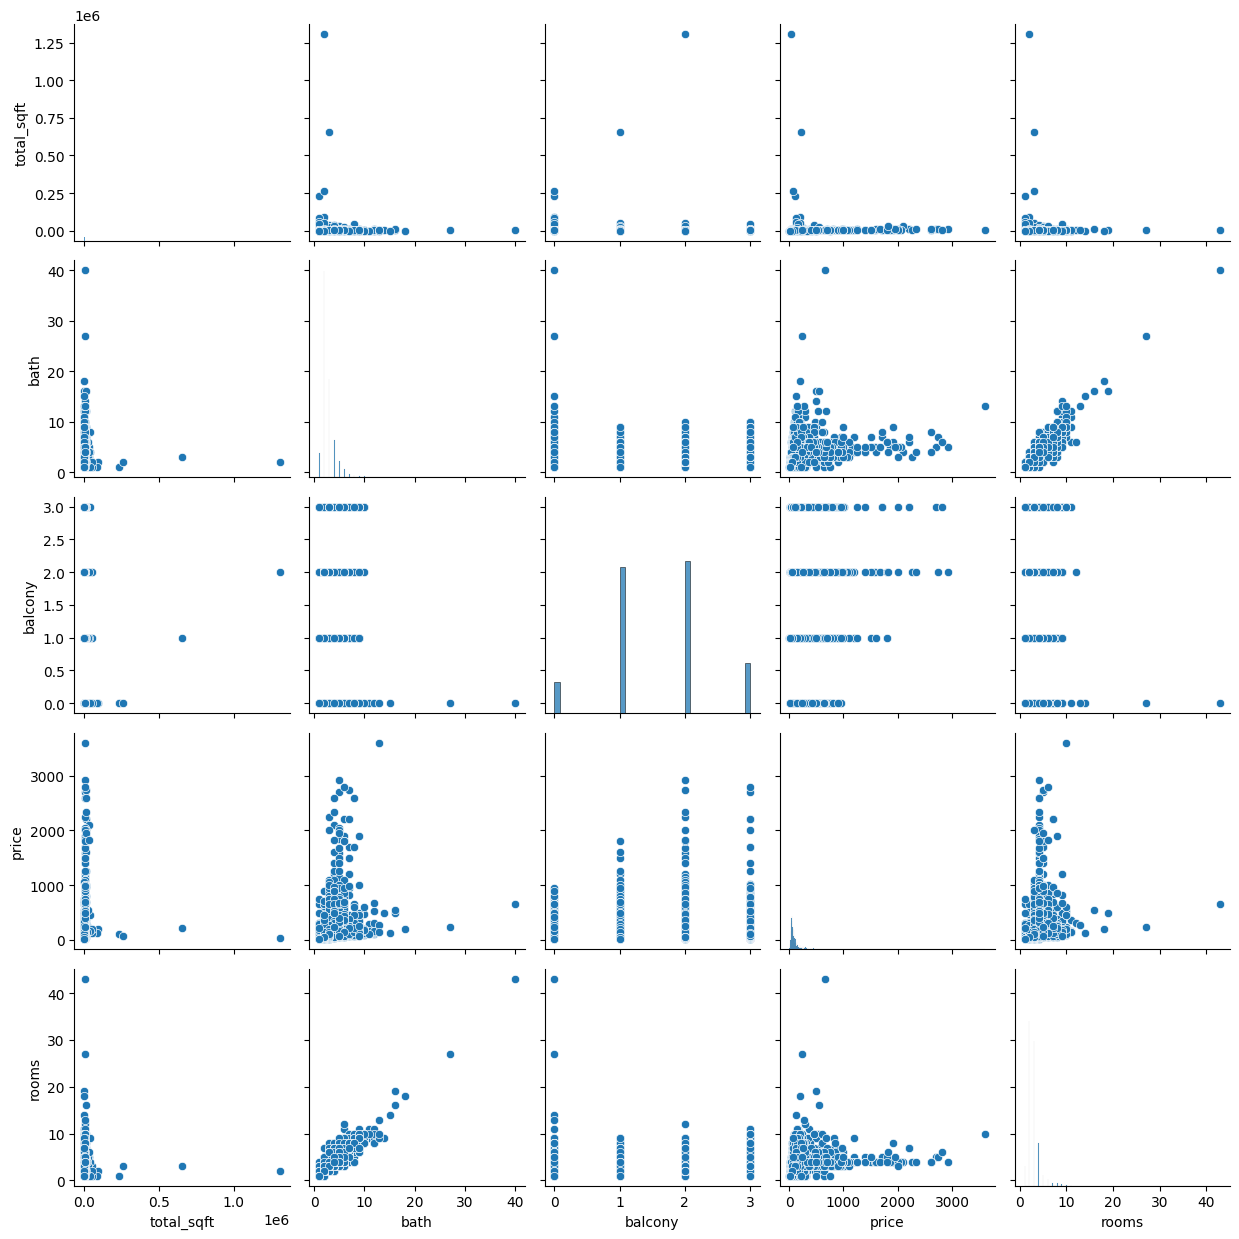

In [9]:
plt.figure(figsize=(8,6))
sns.pairplot(data=df)
plt.tight_layout()
plt.show()

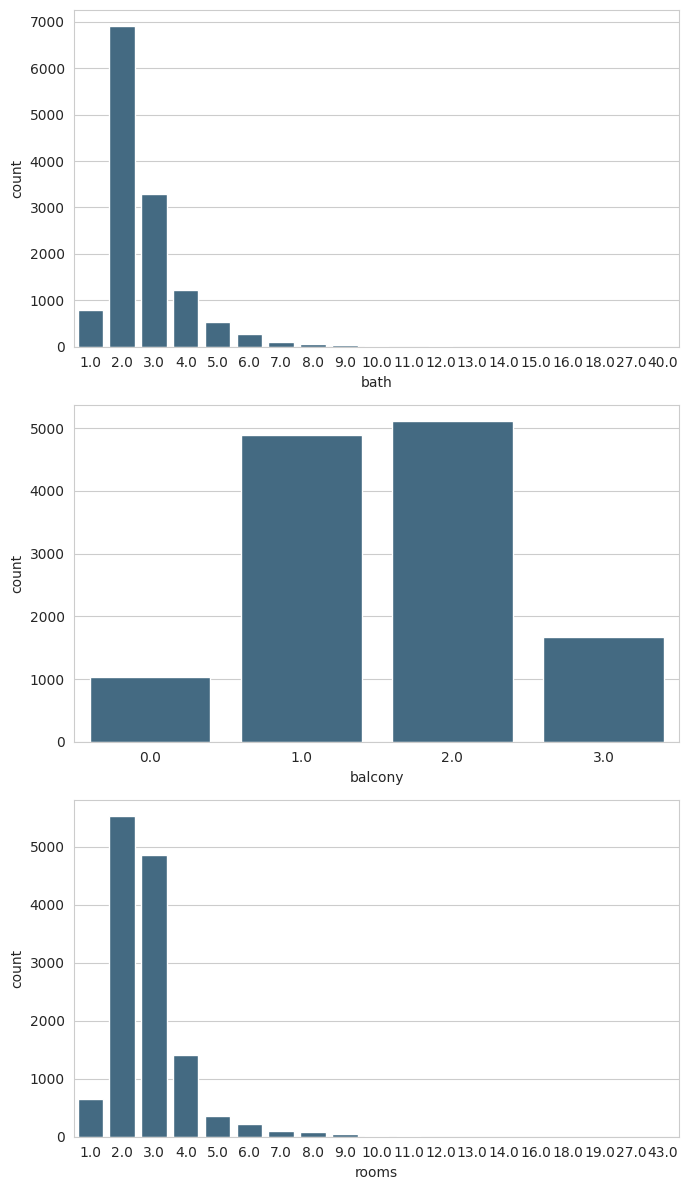

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(7,12))
cols=["bath","balcony","rooms"]
for n,i in enumerate(cols):
    plt.subplot(3,1,n+1)
    sns.countplot(x=i,data=df,color='#3A6D8C')
plt.tight_layout()
plt.show()

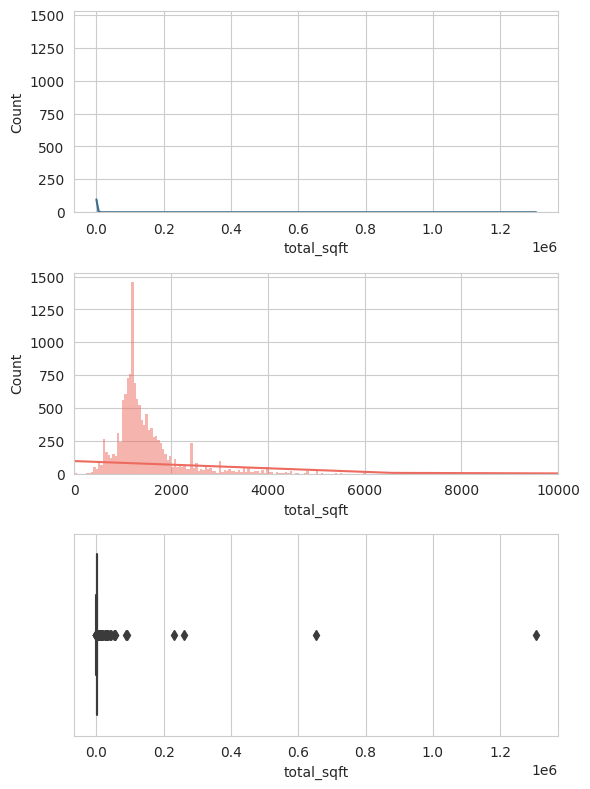

In [13]:
plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
sns.histplot(x="total_sqft",data=df,color='#3A6D8C',kde=True)

plt.subplot(3,1,2)
sns.histplot(x="total_sqft",data=df,color='#ED6A5E',kde=True)
plt.xlim(0,10000)

plt.subplot(3,1,3)
sns.boxplot(x="total_sqft",data=df,color='#3A6D8C')

plt.tight_layout()
plt.show()

### it clear from first distribution that there are values above one million aquare meters,and this is illogical

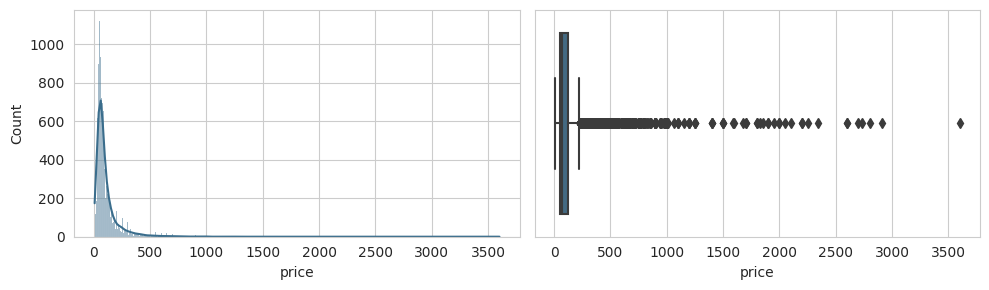

In [17]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.histplot(x="price",data=df,color='#3A6D8C',kde=True)

plt.subplot(1,2,2)
sns.boxplot(x="price",data=df,color='#3A6D8C')


plt.tight_layout()
plt.show()

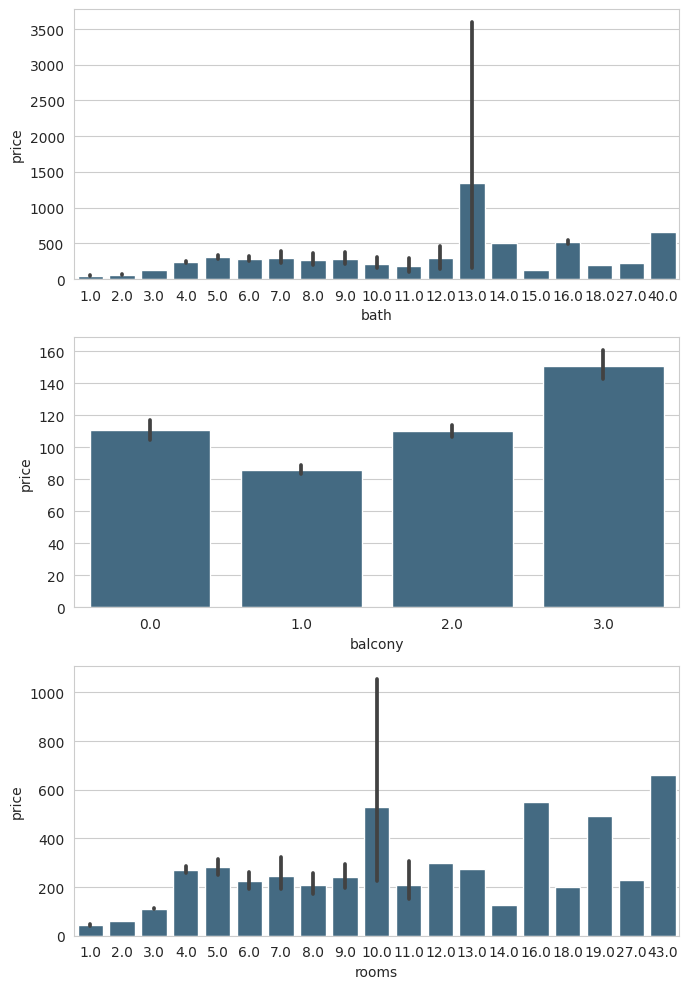

In [29]:
plt.figure(figsize=(7,10))
cols=["bath","balcony","rooms"]
for n,i in enumerate(cols):
    plt.subplot(3,1,n+1)
    sns.barplot(x=i,y="price",data=df,color='#3A6D8C')
plt.tight_layout()
plt.show()

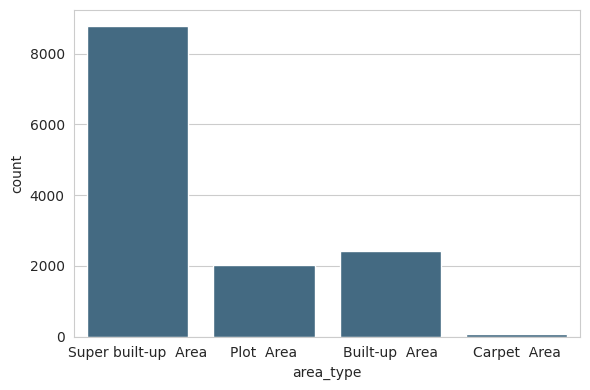

In [46]:
plt.figure(figsize=(6,4))
sns.countplot(x="area_type",data=df,color='#3A6D8C')
plt.tight_layout()
plt.show()

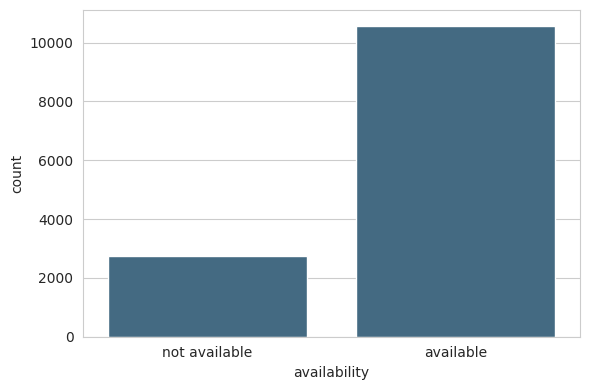

In [49]:
plt.figure(figsize=(6,4))
sns.countplot(x="availability",data=df,color='#3A6D8C')
plt.tight_layout()
plt.show()

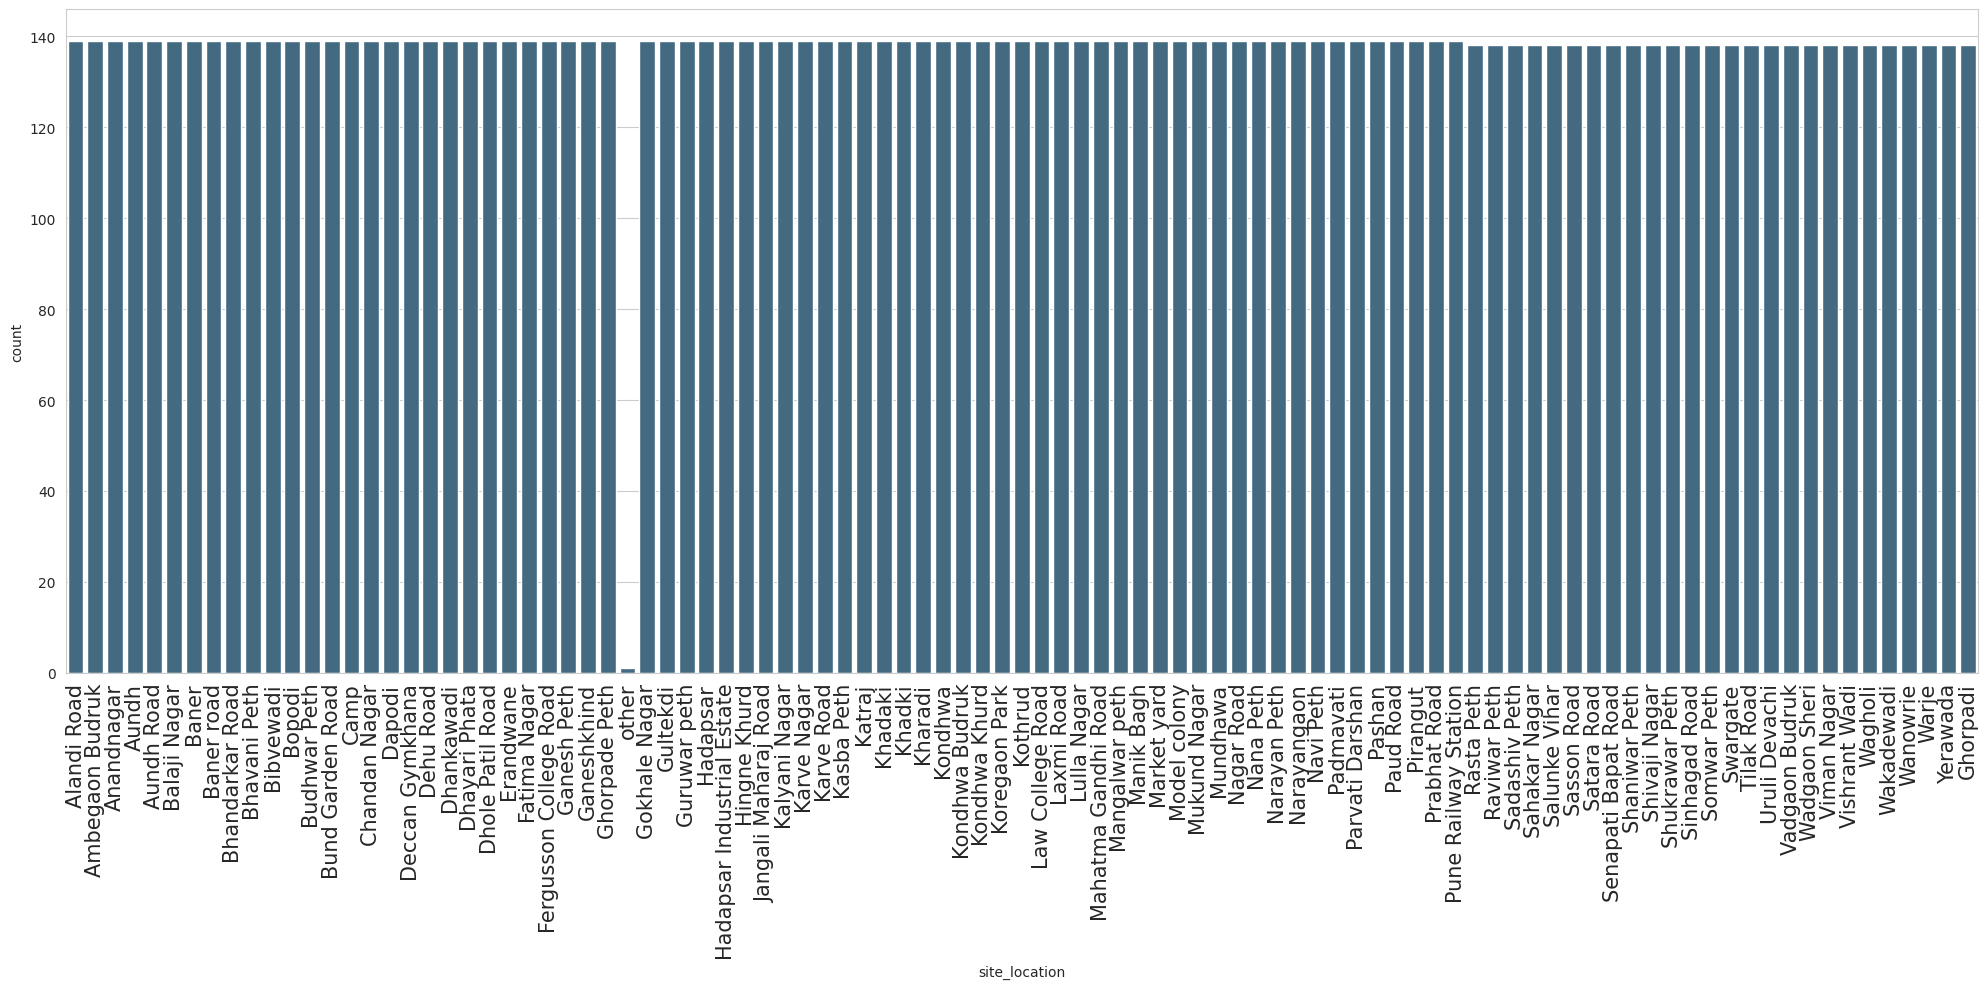

In [51]:
plt.figure(figsize=(20,10))
sns.countplot(x="site_location",data=df,color='#3A6D8C',)
plt.xticks(rotation=90,size=15)
plt.tight_layout()
plt.show()

### replace "other" with Nans

In [9]:
df["site_location"]=df["site_location"].replace("other",np.nan)

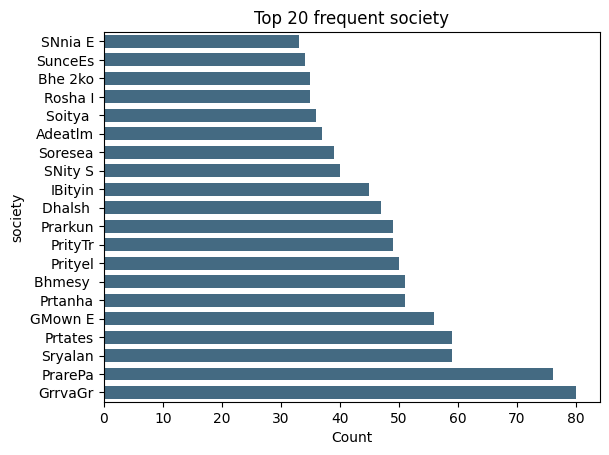

In [20]:
top_values = df["society"].value_counts().head(20).sort_values(ascending=True)
sns.barplot(x=top_values.values, y=top_values.index,color='#3A6D8C',width=.7)
plt.title("Top 20 frequent society")
plt.xlabel("Count")
plt.ylabel("society")
plt.show()

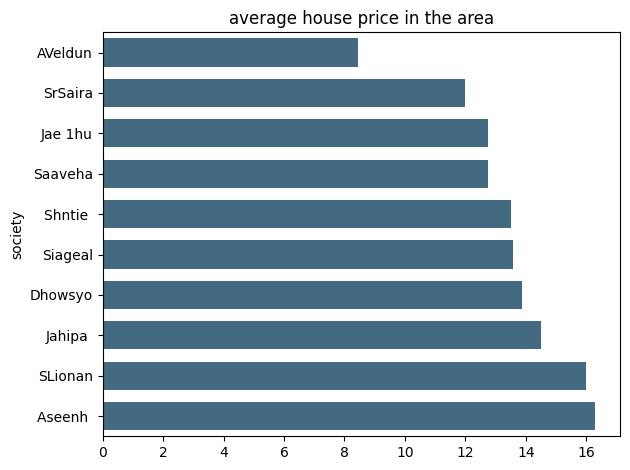

In [17]:
ave_price_in_area=df.groupby("society")["price"].mean().sort_values(ascending=True).head(10)
sns.barplot(x=ave_price_in_area.values,y=ave_price_in_area.index,color='#3A6D8C',width=.7)
plt.title("average house price in the area")
plt.tight_layout()
plt.show()

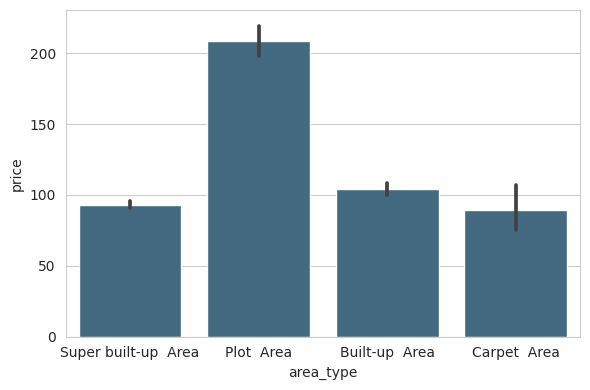

In [70]:
plt.figure(figsize=(6,4))
sns.barplot(x="area_type",y="price",data=df,color='#3A6D8C')
plt.tight_layout()
plt.show()

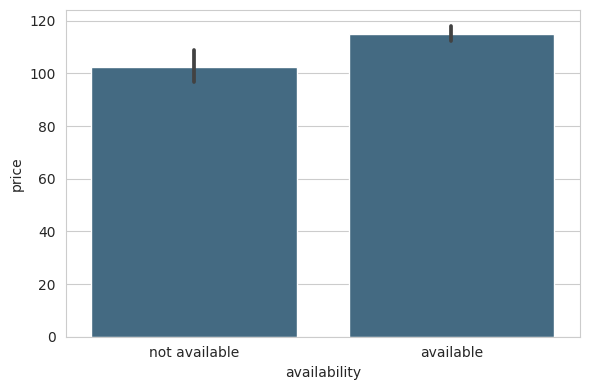

In [71]:
plt.figure(figsize=(6,4))
sns.barplot(x="availability",y="price",data=df,color='#3A6D8C')
plt.tight_layout()
plt.show()

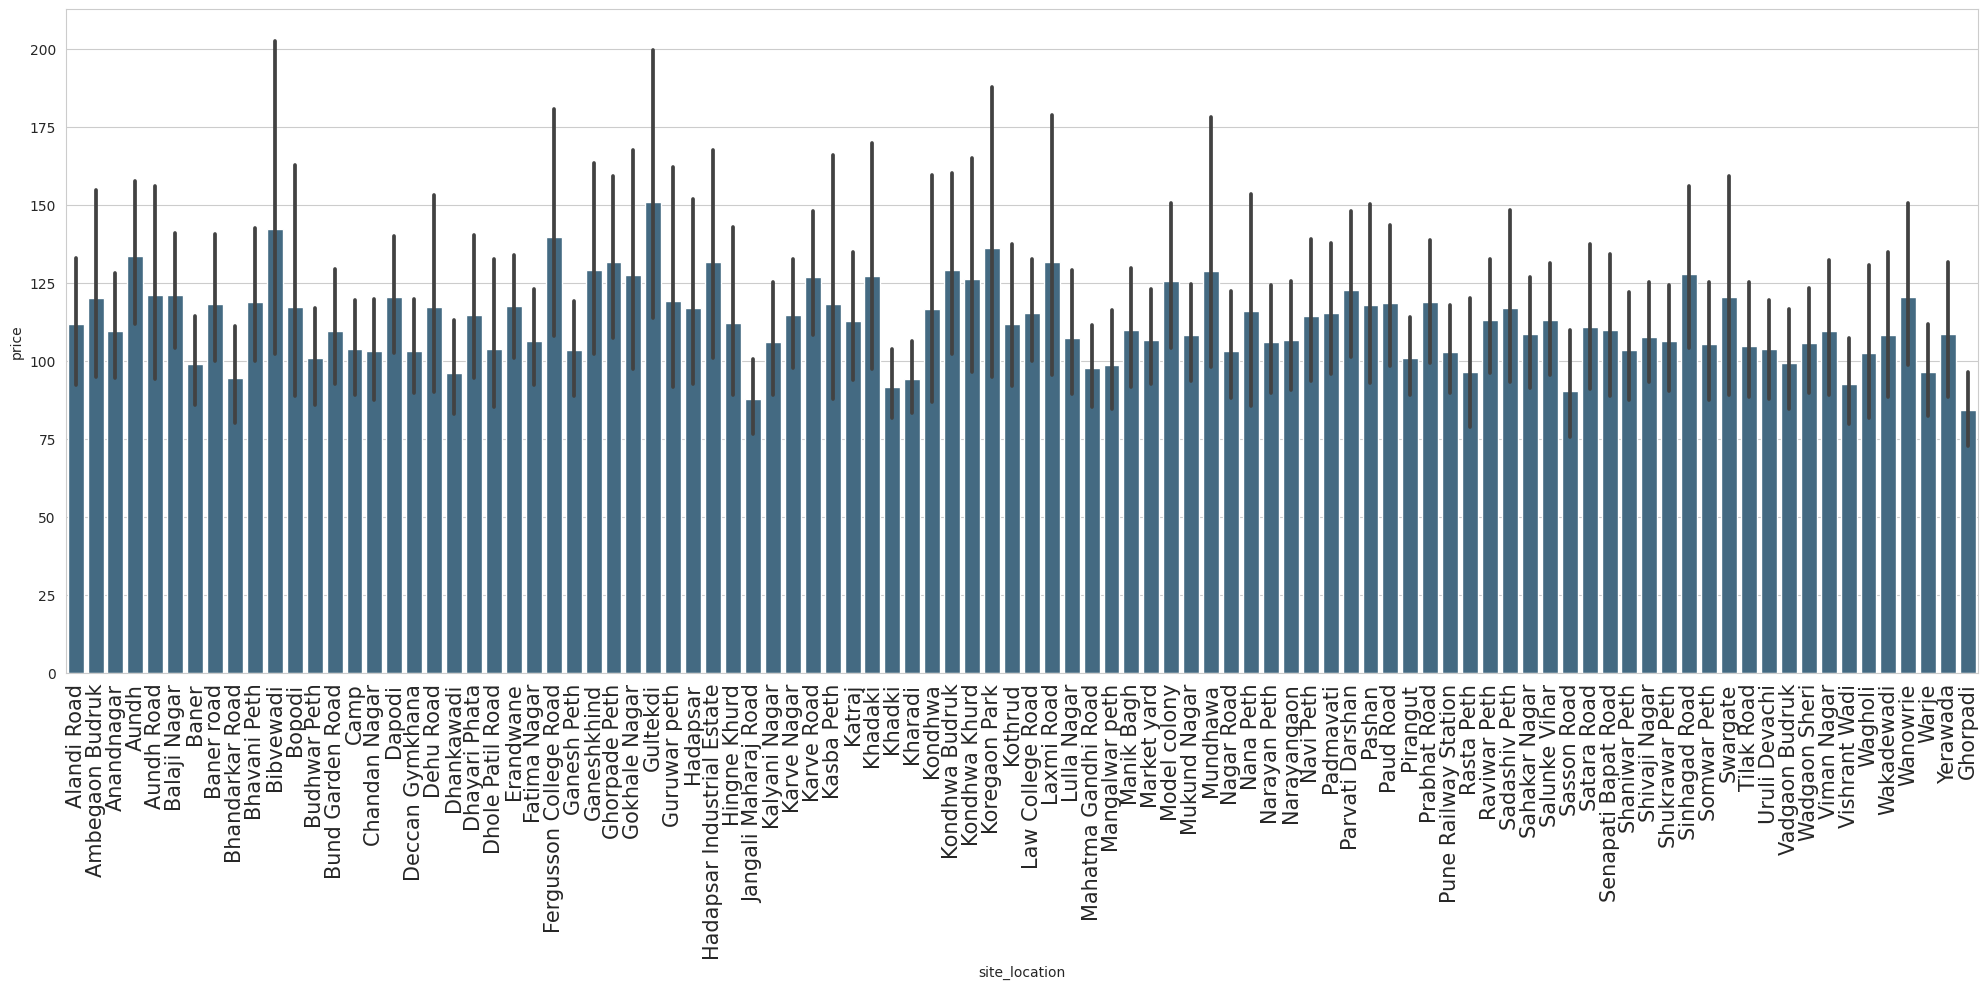

In [72]:
plt.figure(figsize=(20,10))
sns.barplot(x="site_location",y="price",data=df,color='#3A6D8C',)
plt.xticks(rotation=90,size=15)
plt.tight_layout()
plt.show()

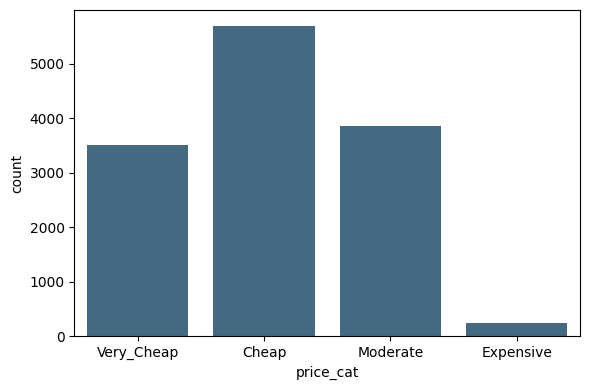

In [10]:
bins = [0, 50, 100, 500, np.inf]
labels = ["Very_Cheap", "Cheap", "Moderate", "Expensive"]
df["price_cat"] = pd.cut(df["price"], bins=bins, labels=labels)

plt.figure(figsize=(6,4))
sns.countplot(x=df["price_cat"],color="#3A6D8C")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [11]:
#combine features
df["price_per_sqft"] = (df["price"] * 100000) / df["total_sqft"]
df["total_rooms"] = df["rooms"] + df["bath"]
df["room_density"] = df["total_rooms"] / df["total_sqft"]

# Split the data

In [12]:
train_set, test_set = train_test_split(
    df, test_size=0.2, stratify=df["price_cat"], random_state=42)

**I use 'cat_price' to make stratifing to data after i will drop it**

In [13]:
for i in (train_set, test_set):
     i.drop("price_cat", axis=1, inplace=True)

In [14]:
df_train=train_set.copy()

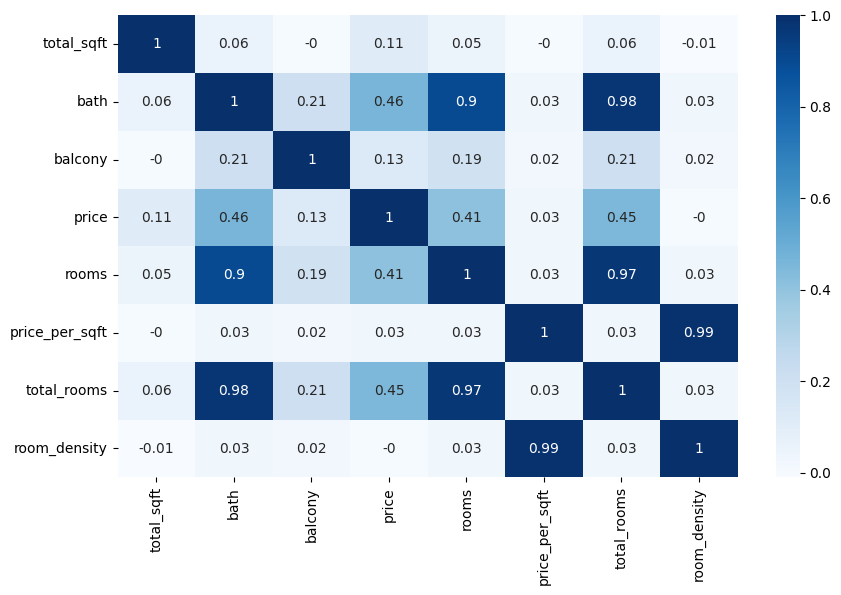

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(df_train.corr(numeric_only=True).round(2),annot=True,cmap = "Blues")
plt.show()

In [41]:
x=train_set.drop("price",axis=1)  #featurs
y=train_set["price"]  #target

In [42]:
# measure skew of numerical features
nums=df_train.select_dtypes(include='number')
nums.skew().round(2)

total_sqft        70.74
bath               4.67
balcony            0.01
price              7.86
rooms              5.39
price_per_sqft    97.29
total_rooms        5.23
room_density      89.43
dtype: Float64

# Preprocessing

In [46]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson')), 
    ('scaler', RobustScaler())
])
soc_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant',fill_value='Unknown')),
    ('encoder', TargetEncoder()),
    ('scaler', RobustScaler())
])
location_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder()),
    ('scaler', RobustScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])    

In [47]:
rcat=["area_type","availability"]
numeric=x.select_dtypes(include="number").columns.tolist()
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric),
    ('cat', cat_pipeline, rcat),
    ('soc',soc_pipeline,["society"]),
    ('loc',location_pipeline,["site_location"])
])

full_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection',SelectKBest(score_func=f_regression)),
    ('model', LinearRegression())
])

# Model Selection and hyperparameter tuning

In [48]:
param_grid=[
    {
        'model':[LinearRegression()],
        'feature_selection__k': [5, 'all']
    },
    {
        'model':[RandomForestRegressor(random_state=42)],
        'feature_selection__k': [5, 'all'],
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20]
    },
    {
        'model':[SVR()],
        'feature_selection__k': [5, 'all'],
        'model__C': [1, 10],
        'model__kernel': ['linear', 'rbf']
    }
]
grid = GridSearchCV(full_pipeline,param_grid,cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)

grid.fit(x,y)

print("Best model:", grid.best_estimator_)
print("Best score (RMSE):", -grid.best_score_)

Best model: Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['total_sqft', 'bath',
                                                   'balcony', 'rooms',
                                                   'price_per_sqft',
                                                   'total_rooms',
                                                   'room_density']),
                                          

# model Evaluation 

In [49]:
x_test=test_set.drop("price",axis=1)
y_test=test_set["price"]

In [63]:
y_pred=grid.best_estimator_.predict(x_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root MSE

print("R2 Score:", r2*100)
print("MSE:", mse)
print("RMSE:", rmse)

R2 Score: 97.67672554149853
MSE: 659.6071377611431
RMSE: 25.682817948214776
